# Préparation des données

Ce bloc importe les bibliothèques nécessaires pour le projet :

* os : pour les opérations de gestion de fichiers et dossiers.
* cv2 (OpenCV) : pour le traitement d'images.
* numpy : pour les opérations mathématiques et les manipulations de tableaux.
* torch et ses sous-modules : pour construire et entraîner des modèles en apprentissage profond.
* drive : pour monter Google Drive dans Google Colab et accéder aux fichiers stockés dans le Drive.

In [22]:
# Importations nécessaires
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
from sklearn.metrics import mean_squared_error
import torchvision.utils as vutils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths to the dataset
peds1_train_path = r'/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
peds1_test_path = r'/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'
peds2_train_path = r'/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train'
peds2_test_path = r'/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test'

# Check if files are present
def check_files(folder_path):
    print(f"Files in {folder_path}:")
    for file in os.listdir(folder_path):
        print(file)

check_files(peds1_train_path)
check_files(peds1_test_path)
check_files(peds2_train_path)
check_files(peds2_test_path)

Mounted at /content/drive
Files in /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train:
Train034
Train033
Train032
Train031
Train030
Train029
Train026
Train027
Train028
Train025
Train024
Train023
Train022
Train021
Train020
Train019
Train018
Train017
Train016
Train015
Train014
Train013
Train012
Train011
Train010
Train009
Train008
Train007
Train006
Train005
Train004
Train002
Train003
Train001
.DS_Store
._.DS_Store
Files in /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test:
Test036
Test035
Test034
Test033
Test032_gt
Test032
Test031
Test028
Test030
Test029
Test027
Test026
Test025
Test024_gt
Test024
Test023_gt
Test023
Test022_gt
Test022
Test021_gt
Test021
Test020
Test019_gt
Test019
Test018_gt
Test018
Test017
Test016
Test015
Test014_gt
Test014
Test013
Test010
Test011
Test012
Test009
Test008
Test007
Test005
Test004_gt
Test006
Test004
Test003_gt
Test002
Test001
Test003
.DS_Store
._UCSDped1.m
UCSDped1.m
UCSDped1.m~
Files in /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1

In [21]:
# Function to load images from a folder
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []

    for root, dirs, files in os.walk(folder_path):  # Walk through all subdirectories
        for file in files:
            # Include .tif and .bmp formats, and exclude specific patterns
            if (file.endswith((".tif", ".bmp")) and
                not file.startswith("test") and
                not file.endswith("_gt.tif") and
                not file.endswith("_gt.bmp")):

                image_path = os.path.join(root, file)
                print(f"Loading image: {image_path}")  # Debugging output
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Read the image
                if image is not None:
                    # Resize and normalize
                    image = cv2.resize(image, image_size)

                    # Check the number of channels
                    if len(image.shape) == 2:  # Grayscale image
                        images.append(image / 255.0)  # Normalize to [0,1]
                    elif len(image.shape) == 3:  # Color image
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                        images.append(image / 255.0)  # Normalize to [0,1]
                    else:
                        print(f"Unexpected image shape: {image.shape} for {image_path}")
                else:
                    print(f"Could not load image: {image_path}")  # Debugging output

    return np.array(images)

# Load the training images
peds1_train_images = load_images_from_folder(peds1_train_path)
peds2_train_images = load_images_from_folder(peds2_train_path)

print("Loaded Peds1 train images shape:", peds1_train_images.shape)
print("Loaded Peds2 train images shape:", peds2_train_images.shape)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/012.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/105.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/021.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/118.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/139.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/091.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/170.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/144.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train013/082.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset

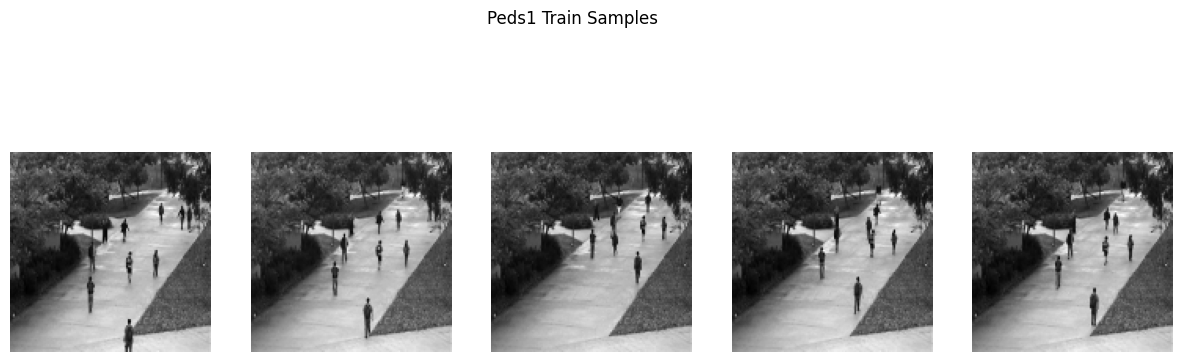

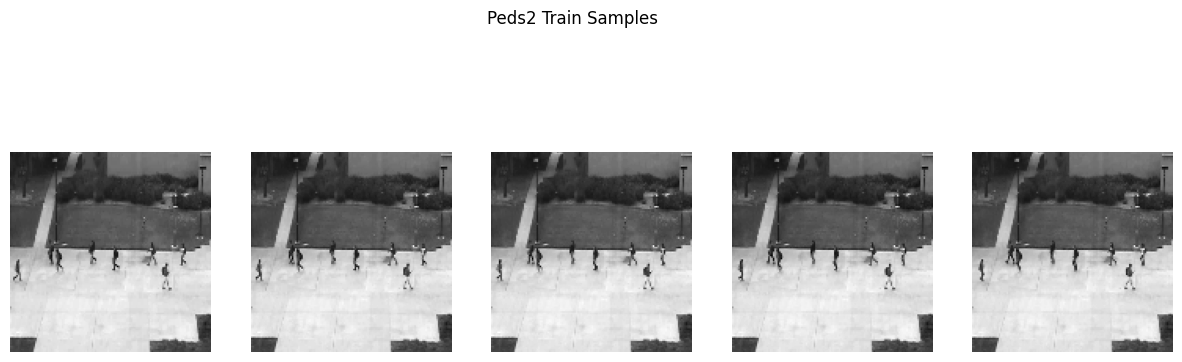

In [23]:
import matplotlib.pyplot as plt

def visualize_samples(images, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize samples from Peds1 and Peds2 train images
visualize_samples(peds1_train_images, "Peds1 Train Samples")
visualize_samples(peds2_train_images, "Peds2 Train Samples")

# Prépapartion du générateur et descriminateur

In [ ]:

# Classe Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(128, 128)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.img_flatten_size = int(np.prod(img_shape))  # Produit des dimensions d'image

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, self.img_flatten_size),
            nn.Tanh()  # output entre -1 et 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, *self.img_shape)  # Ajouter un canal pour l'image
        return img

In [ ]:
# Classe Discriminator (Critic pour WGAN)
class Critic(nn.Module):
    def __init__(self, img_shape=(128, 128)):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [ ]:
# Hyperparamètres ajustés
latent_dim = 100
img_shape = (128, 128)
n_epochs = 20
n_critic = 7  # Augmenté pour stabiliser l'entraînement
clip_value = 0.005  # Valeur de clipping ajustée

# Initialisation des modèles
generator = Generator(latent_dim, img_shape)  # Créer une instance du générateur
critic = Critic(img_shape)  # Créer une instance du critic

# Optimiseurs avec un taux d'apprentissage ajusté
learning_rate_G = 0.0001  # Testez avec 0.0001
learning_rate_C = 0.0001  # Testez avec 0.0001
optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate_G)  # Utiliser l'instance
optimizer_C = optim.RMSprop(critic.parameters(), lr=learning_rate_C)  # Utiliser l'instance

# Préparation des données (inchangée)
train_data = np.concatenate((peds1_train_images, peds2_train_images), axis=0)
train_data = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
dataloader = DataLoader(TensorDataset(train_data), batch_size=64, shuffle=True)

# Entrainement du modèle

[Epoch 0/20] [Critic loss: -2.834275245666504] [Generator loss: 0.4359253942966461] [MSE Loss: 0.023258676752448082]
[Epoch 1/20] [Critic loss: -4.708765506744385] [Generator loss: -3.2150790691375732] [MSE Loss: 0.09899914264678955]
[Epoch 2/20] [Critic loss: 0.08994424343109131] [Generator loss: -1.1463834047317505] [MSE Loss: 0.025205379351973534]
[Epoch 3/20] [Critic loss: -0.009454816579818726] [Generator loss: 0.8937368988990784] [MSE Loss: 0.01269418653100729]
[Epoch 4/20] [Critic loss: -0.6838182210922241] [Generator loss: 0.36767616868019104] [MSE Loss: 0.03063639998435974]
[Epoch 5/20] [Critic loss: -0.46151942014694214] [Generator loss: 0.06149427220225334] [MSE Loss: 0.033732738345861435]
[Epoch 6/20] [Critic loss: -0.6270953416824341] [Generator loss: 3.0375940799713135] [MSE Loss: 0.06089480593800545]
[Epoch 7/20] [Critic loss: 0.04545290023088455] [Generator loss: 0.37807807326316833] [MSE Loss: 0.0415034182369709]
[Epoch 8/20] [Critic loss: -1.1863441467285156] [Generat

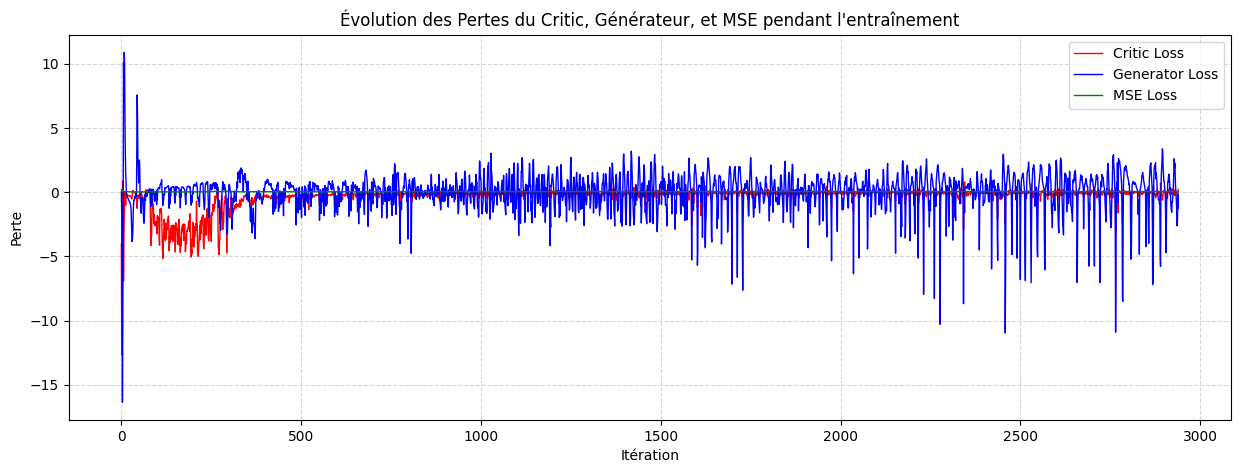

In [ ]:
# Listes pour stocker les pertes et MSE
c_losses = []
g_losses = []
mse_losses = []  # Nouvelle liste pour les pertes MSE

for epoch in range(n_epochs):
    for i, (imgs,) in enumerate(dataloader):
        # Entraînement du Critic
        for _ in range(n_critic):
            optimizer_C.zero_grad()
            z = torch.randn((imgs.size(0), latent_dim))
            real_loss = -torch.mean(critic(imgs))  # Loss pour les images réelles
            fake_loss = torch.mean(critic(generator(z).detach()))  # Loss pour les images générées
            c_loss = real_loss + fake_loss
            c_loss.backward()
            optimizer_C.step()

            # Clipping des poids du Critic
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Entraînement du Générateur
        optimizer_G.zero_grad()
        gen_imgs = generator(z)
        g_loss = -torch.mean(critic(gen_imgs))

        # Calcul de la MSE entre les images générées et les images réelles
        mse_loss = mean_squared_error(imgs.view(-1).detach().cpu().numpy(), gen_imgs.view(-1).detach().cpu().numpy())

        # Stockage des pertes
        mse_losses.append(mse_loss)  # Ajouter la MSE à la liste
        g_loss.backward()
        optimizer_G.step()

        # Stockage des pertes
        c_losses.append(c_loss.item())
        g_losses.append(g_loss.item())

    print(f"[Epoch {epoch}/{n_epochs}] [Critic loss: {c_loss.item()}] [Generator loss: {g_loss.item()}] [MSE Loss: {mse_loss}]")

# Tracer les pertes du Critic, Générateur, et MSE
plt.figure(figsize=(15, 5))
plt.plot(c_losses, label='Critic Loss', color='red', linewidth=1)
plt.plot(g_losses, label='Generator Loss', color='blue', linewidth=1)
plt.plot(mse_losses, label='MSE Loss', color='green', linewidth=1)  # Ajouter MSE Loss
plt.title('Évolution des Pertes du Critic, Générateur, et MSE pendant l\'entraînement')
plt.xlabel('Itération')
plt.ylabel('Perte')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Visualisation de la performance

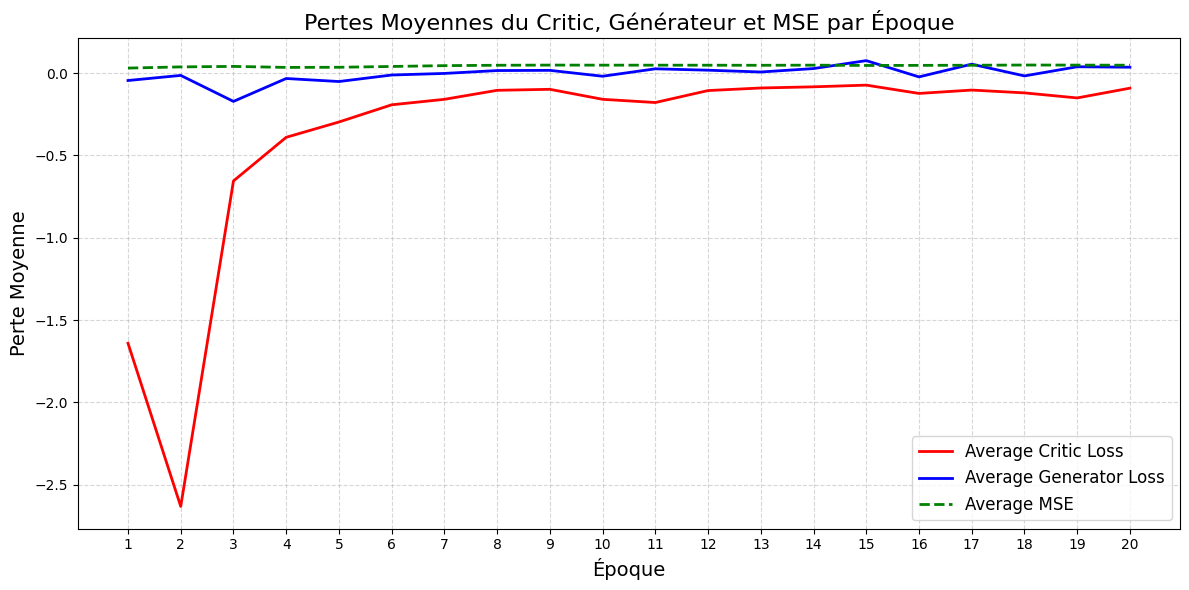

In [ ]:

# Calcul des pertes moyennes par époque
epochs = np.arange(1, n_epochs + 1)
avg_c_losses = [np.mean(c_losses[i * len(dataloader):(i + 1) * len(dataloader)]) for i in range(n_epochs)]
avg_g_losses = [np.mean(g_losses[i * len(dataloader):(i + 1) * len(dataloader)]) for i in range(n_epochs)]
avg_mse_losses = [np.mean(mse_losses[i * len(dataloader):(i + 1) * len(dataloader)]) for i in range(n_epochs)]

# Tracer les pertes moyennes par époque
plt.figure(figsize=(12, 6))
plt.plot(epochs, avg_c_losses, label='Average Critic Loss', color='red', linewidth=2)
plt.plot(epochs, avg_g_losses, label='Average Generator Loss', color='blue', linewidth=2)
plt.plot(epochs, avg_mse_losses, label='Average MSE', color='green', linewidth=2, linestyle='--')

# Ajout de titres et étiquettes
plt.title("Pertes Moyennes du Critic, Générateur et MSE par Époque", fontsize=16)
plt.xlabel("Époque", fontsize=14)
plt.ylabel("Perte Moyenne", fontsize=14)
plt.xticks(epochs)  # Pour afficher chaque époque sur l'axe x
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher le graphique
plt.tight_layout()  # Ajuste automatiquement les marges pour un meilleur affichage
plt.show()

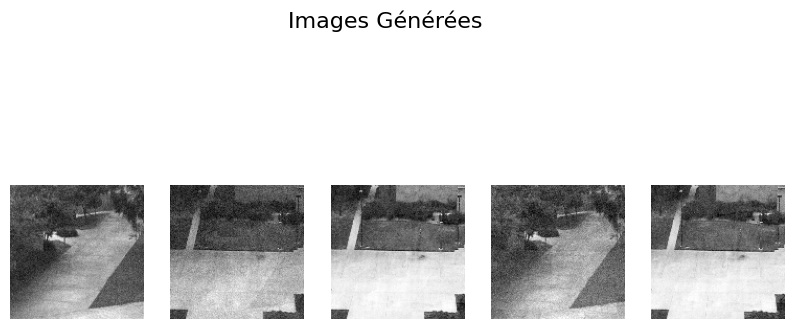

In [ ]:
# Générer et afficher 2 images
def generate_and_display_images(generator, latent_dim, num_images=5, img_shape=(128, 128)):
    # Générer un batch de vecteurs latents (bruit)
    z = torch.randn(num_images, latent_dim)
    gen_imgs = generator(z).detach().cpu().numpy()

    # Redimensionner les images et les renormaliser dans [0, 1] pour l'affichage
    gen_imgs = 0.5 * gen_imgs + 0.5  # Convertir de [-1, 1] à [0, 1]

    # Affichage en ligne
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    fig.suptitle("Images Générées", fontsize=16)

    for i in range(num_images):
        # Obtenir l'image et ajuster son format pour l'affichage
        img = gen_imgs[i][0]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')  # Masquer les axes

    plt.show()

# Générer et afficher 2 images
generate_and_display_images(generator, latent_dim, num_images=5, img_shape=img_shape)


In [25]:
# Charger les images de test
peds1_test_images = load_images_from_folder(peds1_test_path)
peds2_test_images = load_images_from_folder(peds2_test_path)

# Convertir en tenseurs pour l'utilisation avec PyTorch
peds1_test_images_tensor = torch.tensor(peds1_test_images, dtype=torch.float32).unsqueeze(1)
peds2_test_images_tensor = torch.tensor(peds2_test_images, dtype=torch.float32).unsqueeze(1)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/024.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/013.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/033.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/002.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/034.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/025.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/018.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/005.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/022.tif
Loading image: /content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Tes

Testing on Peds1 Test Set
Nombre d'anomalies détectées : 296 sur 9200 images de test.
Threshold utilisé : 0.3893638998270035

Testing on Peds2 Test Set
Nombre d'anomalies détectées : 37 sur 4020 images de test.
Threshold utilisé : 0.549888864159584


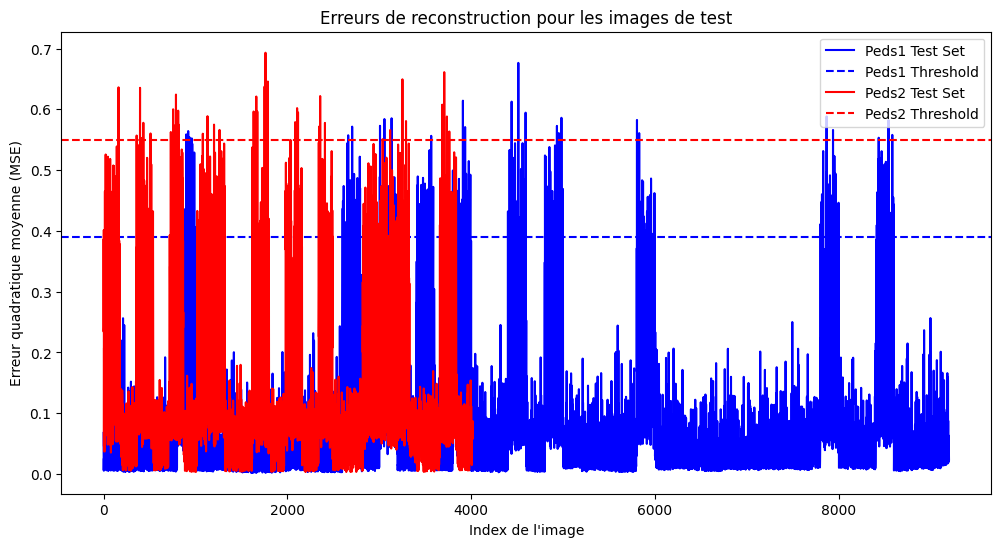

In [26]:
# Fonction pour tester le modèle sur les images de test
def test_model(generator, test_images_tensor, threshold=None):
    generator.eval()  # Mode évaluation pour le générateur
    mse_losses = []

    with torch.no_grad():  # Pas de calcul de gradients pendant l'évaluation
        for img in test_images_tensor:
            # Ajouter une dimension de batch pour l'image de test
            img = img.unsqueeze(0)
            # Générer une image similaire à partir du bruit latent
            z = torch.randn(1, latent_dim)
            gen_img = generator(z)

            # Calculer la MSE entre l'image générée et l'image réelle
            mse_loss = mean_squared_error(img.view(-1).cpu().numpy(), gen_img.view(-1).cpu().numpy())
            mse_losses.append(mse_loss)

    # Calculer un seuil pour détecter les anomalies
    if threshold is None:
        threshold = np.mean(mse_losses) + 3 * np.std(mse_losses)  # Par exemple, seuil basé sur la moyenne et l'écart-type

    # Marquer les images avec une MSE supérieure au seuil comme anomalies
    anomalies = [mse > threshold for mse in mse_losses]
    print(f"Nombre d'anomalies détectées : {sum(anomalies)} sur {len(test_images_tensor)} images de test.")

    return mse_losses, anomalies, threshold

# Tester le modèle sur les images de test de Peds1 et Peds2
print("Testing on Peds1 Test Set")
peds1_mse_losses, peds1_anomalies, peds1_threshold = test_model(generator, peds1_test_images_tensor)
print("Threshold utilisé :", peds1_threshold)

print("\nTesting on Peds2 Test Set")
peds2_mse_losses, peds2_anomalies, peds2_threshold = test_model(generator, peds2_test_images_tensor)
print("Threshold utilisé :", peds2_threshold)

# Tracer les erreurs de reconstruction pour les images de test
plt.figure(figsize=(12, 6))
plt.plot(peds1_mse_losses, label="Peds1 Test Set", color='blue')
plt.axhline(y=peds1_threshold, color='blue', linestyle='--', label="Peds1 Threshold")

plt.plot(peds2_mse_losses, label="Peds2 Test Set", color='red')
plt.axhline(y=peds2_threshold, color='red', linestyle='--', label="Peds2 Threshold")

plt.xlabel("Index de l'image")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Erreurs de reconstruction pour les images de test")
plt.legend()
plt.show()


Anomalies pour le jeu de test Peds1
296 anomalies détectées. Affichage de 5 exemples.


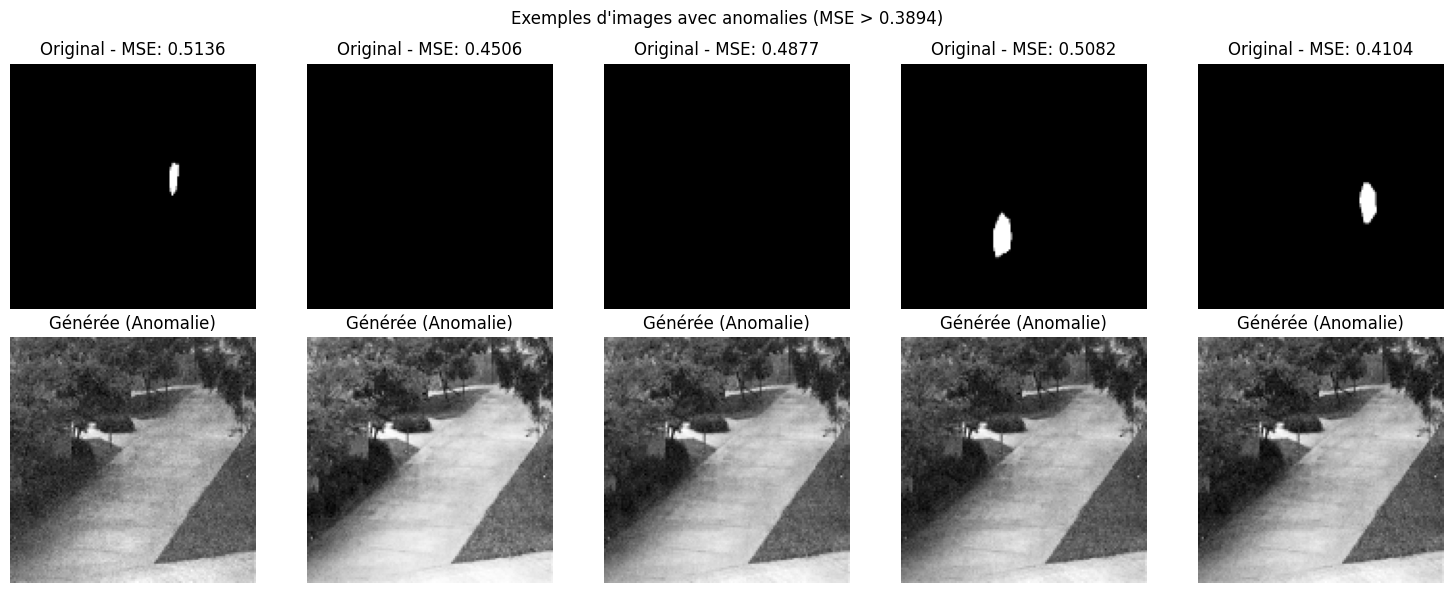


Anomalies pour le jeu de test Peds2
37 anomalies détectées. Affichage de 5 exemples.


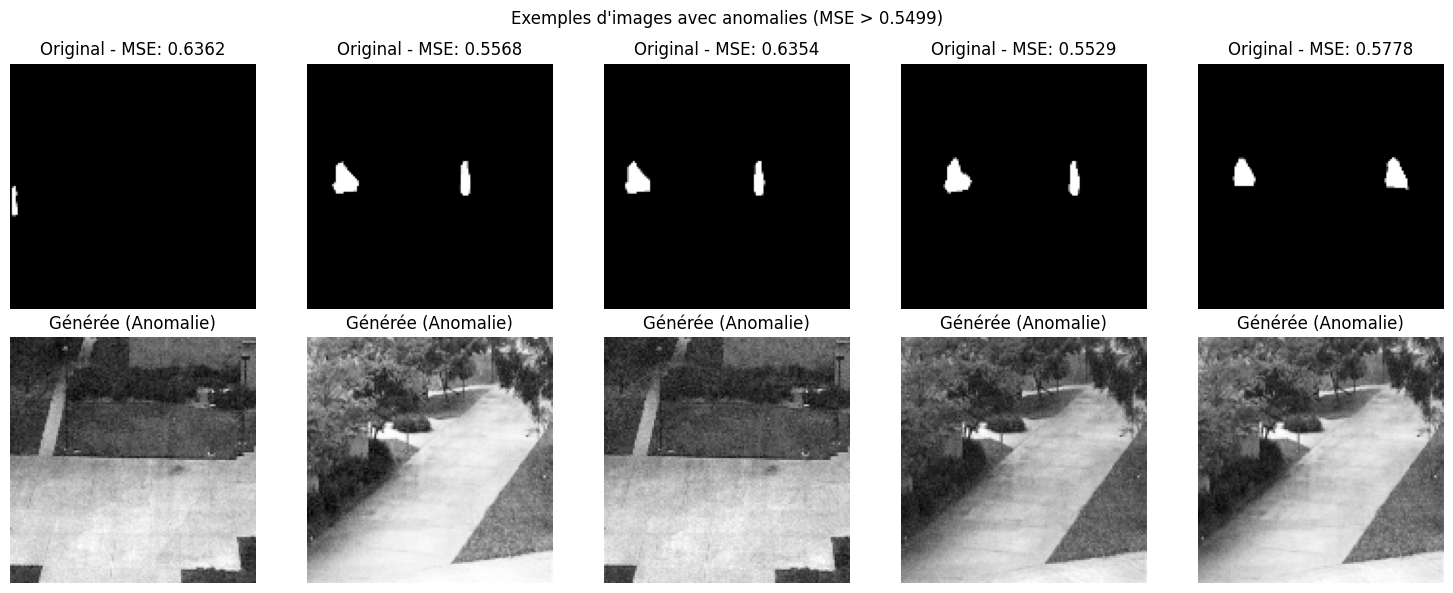

In [28]:
import matplotlib.pyplot as plt

def show_anomalies(test_images_tensor, mse_losses, anomalies, threshold, num_examples=5):
    # Filtrer les images avec des anomalies
    anomaly_indices = [i for i, is_anomaly in enumerate(anomalies) if is_anomaly]

    if len(anomaly_indices) == 0:
        print("Aucune anomalie détectée au-dessus du seuil.")
        return

    print(f"{len(anomaly_indices)} anomalies détectées. Affichage de {min(num_examples, len(anomaly_indices))} exemples.")

    # Limiter le nombre d'images affichées
    anomaly_indices = anomaly_indices[:num_examples]

    fig, axes = plt.subplots(2, len(anomaly_indices), figsize=(15, 6))

    with torch.no_grad():
        for i, idx in enumerate(anomaly_indices):
            # Image originale
            original_image = test_images_tensor[idx].squeeze().cpu().numpy()
            axes[0, i].imshow(original_image, cmap='gray')
            axes[0, i].set_title(f"Original - MSE: {mse_losses[idx]:.4f}")
            axes[0, i].axis("off")

            # Image générée
            z = torch.randn(1, latent_dim)
            generated_image = generator(z).squeeze().cpu().numpy()
            axes[1, i].imshow(generated_image, cmap='gray')
            axes[1, i].set_title("Générée (Anomalie)")
            axes[1, i].axis("off")

    plt.suptitle(f"Exemples d'images avec anomalies (MSE > {threshold:.4f})")
    plt.tight_layout()
    plt.show()

# Afficher les anomalies détectées pour Peds1
print("Anomalies pour le jeu de test Peds1")
show_anomalies(peds1_test_images_tensor, peds1_mse_losses, peds1_anomalies, peds1_threshold)

# Afficher les anomalies détectées pour Peds2
print("\nAnomalies pour le jeu de test Peds2")
show_anomalies(peds2_test_images_tensor, peds2_mse_losses, peds2_anomalies, peds2_threshold)


In [48]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Vérification des tailles des images et des étiquettes
print("Taille des images de test Peds2:", len(peds2_test_images_tensor))
print("Taille des étiquettes réelles Peds2:", len(peds2_true_labels))

# Assurez-vous que les tailles des images et des étiquettes sont égales
peds2_true_labels = peds2_true_labels[:len(peds2_test_images_tensor)]  # Réduit les étiquettes pour correspondre aux images

# Vérification
assert len(peds2_test_images_tensor) == len(peds2_true_labels), \
    f"Erreur : nombre d'images ({len(peds2_test_images_tensor)}) et nombre d'étiquettes ({len(peds2_true_labels)}) ne sont pas égaux."

# Fonction de test avec métriques
def test_model_with_metrics(generator, test_images, true_labels, threshold=0.5):
    # Calcul des pertes MSE entre les images et les images générées
    mse_losses = []
    with torch.no_grad():  # Pas de calcul de gradients
        for img in test_images:
            img = img.unsqueeze(0)  # Ajouter une dimension de batch
            z = torch.randn(1, latent_dim)  # Bruit latent
            gen_img = generator(z)  # Image générée
            mse_loss = ((img - gen_img) ** 2).mean().item()  # Calcul de la MSE
            mse_losses.append(mse_loss)

    # Détection des anomalies : Si la perte MSE dépasse le seuil, c'est une anomalie
    anomalies = np.array(mse_losses) > threshold

    # Calcul des métriques
    accuracy = accuracy_score(true_labels, anomalies)
    recall = recall_score(true_labels, anomalies)
    f1 = f1_score(true_labels, anomalies)
    cm = confusion_matrix(true_labels, anomalies)

    # Retourner les métriques et les anomalies détectées
    return mse_losses, anomalies, threshold, accuracy, recall, f1, cm

# Utilisation de la fonction de test sur Peds2
peds2_mse_losses, peds2_anomalies, peds2_threshold, peds2_accuracy, peds2_recall, peds2_f1, peds2_cm = test_model_with_metrics(
    generator, peds2_test_images_tensor, peds2_true_labels, threshold=0.5384164899587631  # Utilisation du seuil calculé précédemment
)

# Affichage des résultats
print(f"Nombre d'anomalies détectées : {np.sum(peds2_anomalies)} sur {len(peds2_test_images_tensor)} images de test.")
print(f"Threshold utilisé : {peds2_threshold}")
print("Métriques de performance :")
print(f"Accuracy: {peds2_accuracy:.4f}")
print(f"Recall (Sensitivity): {peds2_recall:.4f}")
print(f"F1-score: {peds2_f1:.4f}")
print("Confusion Matrix:")
print(f"TN={peds2_cm[0, 0]}, FP={peds2_cm[0, 1]}")
print(f"FN={peds2_cm[1, 0]}, TP={peds2_cm[1, 1]}")


Taille des images de test Peds2: 4020
Taille des étiquettes réelles Peds2: 4020
Nombre d'anomalies détectées : 41 sur 4020 images de test.
Threshold utilisé : 0.5384164899587631
Métriques de performance :
Accuracy: 0.5164
Recall (Sensitivity): 0.0103
F1-score: 0.0202
Confusion Matrix:
TN=2056, FP=21
FN=1923, TP=20
